In [3]:

from skimage import feature


#from utils.utils import *

import numpy as np

from pylab import cm

from matplotlib import pyplot as plt


import time

import imageio

import os

from iterators import *

import tensorlayer as tl
from matplotlib import pyplot as plt
from model import network
from tqdm import tqdm
import time
from vgg.vgg16 import VGG16

from config import *
from preprocessing import *

ModuleNotFoundError: No module named 'iterators'

In [4]:
batch_size = config.TRAIN.batch_size
lr_init = config.TRAIN.lr_init

n_epoch = config.TRAIN.n_epoch

lr_decay = config.TRAIN.lr_decay
decay_every = config.TRAIN.decay_every

t_size = config.TRAIN.model_size

mask_type = config.TRAIN.mask_type

vgg16_npy_path = config.TRAIN.vgg_path


 ** init lr: 0.001000  decay_every_init: 10, lr_decay: 0.100000 

  0%|          | 0/295 [00:00<?, ?it/s]

Validation: Epoch -1  val mse 0.0

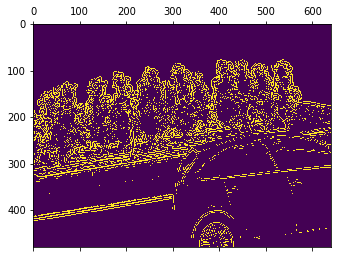

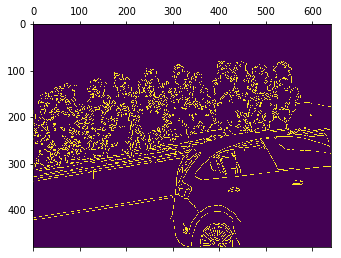

In [5]:
train_d_img_list, train_rgb_img_list = sorted(get_synthia_imgs_list(config.VALID.hr_img_path, is_train=True, synthia_dataset=config.TRAIN.hr_img_path, return_rgb = True))
valid_d_img_list, valid_rgb_img_list = sorted(get_synthia_imgs_list(config.VALID.hr_img_path, is_train=False, synthia_dataset=config.TRAIN.hr_img_path, return_rgb = True))
print('Total Train Examples = ', len(train_d_img_list))
print('Total Val Examples = ', len(valid_d_img_list))


 ** init lr: 0.001000  decay_every_init: 10, lr_decay: 0.100000 

  0%|          | 0/295 [00:00<?, ?it/s]

Validation: Epoch -1  val mse 0.0

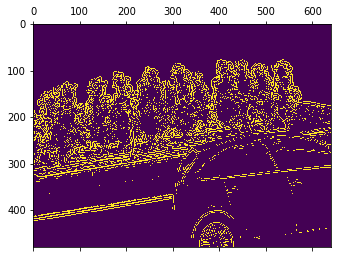

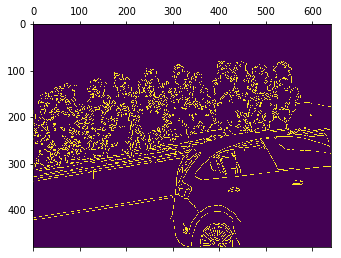

In [7]:

##---sample images -----------

val_image_s = open_rgb(valid_rgb_img_list[0])[None, :, :, :]
val_gt_s = open_depth_synthia(valid_d_img_list[0], debug=True)[None]
val_image_d = open_rgb(valid_rgb_img_list[-1])[None, :, :, :]
val_gt_d = open_depth_synthia(valid_d_img_list[-1])[None, :, :, :]


 ** init lr: 0.001000  decay_every_init: 10, lr_decay: 0.100000 

  0%|          | 0/295 [00:00<?, ?it/s]

Validation: Epoch -1  val mse 0.0

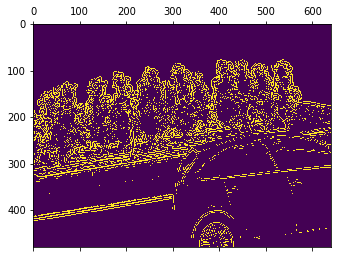

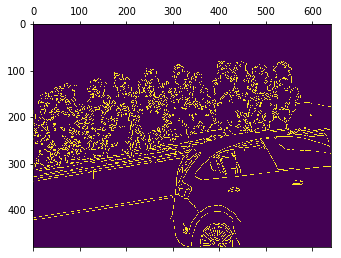

In [8]:

###========================== DEFINE MODEL ============================###
## train inference
t_input_d = tf.placeholder(tf.float32, shape=(None, None, None, 1), name='t_input')
#t_input_rgb = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='t_input_rgb')
t_edges = tf.placeholder(tf.bool, shape=(None, None, None, 1), name='t_edges')
t_mask = tf.placeholder(tf.float32, shape=(None, None, None, 1), name='t_mask')

d_flg = tf.placeholder(tf.bool, name = 'is_train')


 ** init lr: 0.001000  decay_every_init: 10, lr_decay: 0.100000 

  0%|          | 0/295 [00:00<?, ?it/s]

Validation: Epoch -1  val mse 0.0

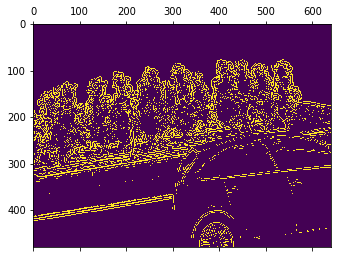

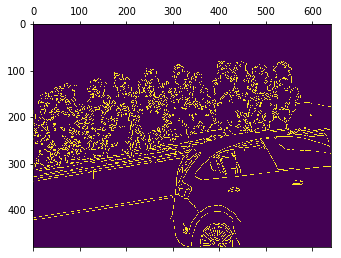

In [9]:
t_depth, mean_d, t_target_depth, t_edges = preprocess(t_input_d, t_mask, t_edges, t_size)

net_g_outputs = network(t_depth,t_edges,is_train=d_flg)
net_g_outputs = return2original_scale(net_g_outputs, mean_d)

mse_loss =  tf.reduce_mean(tf.square(t_target_depth - net_g_outputs))

g_loss = mse_loss

glob_step_t = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

with tf.variable_scope('learning_rate'):
    lr_v = tf.Variable(lr_init, trainable=False)
    optim = tf.train.AdamOptimizer(lr_v).minimize(g_loss, global_step=glob_step_t)


 ** init lr: 0.001000  decay_every_init: 10, lr_decay: 0.100000 

  0%|          | 0/295 [00:00<?, ?it/s]

Validation: Epoch -1  val mse 0.0

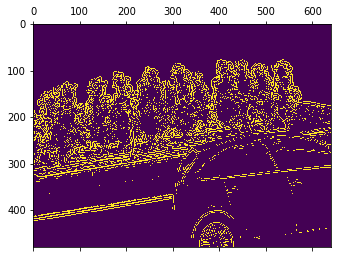

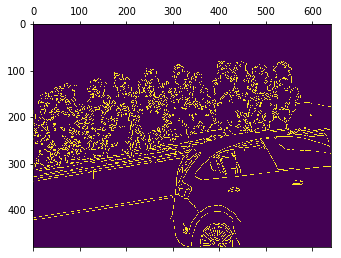

In [10]:
saver = tf.train.Saver(max_to_keep=5)
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))

sess.run(tf.global_variables_initializer())


 ** init lr: 0.001000  decay_every_init: 10, lr_decay: 0.100000 

  0%|          | 0/295 [00:00<?, ?it/s]

Validation: Epoch -1  val mse 0.0

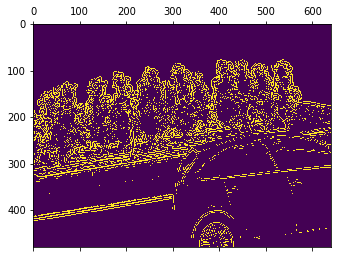

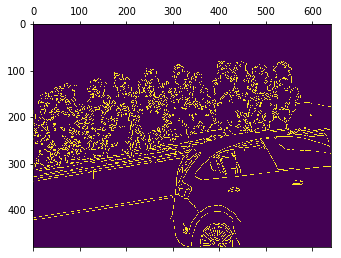

In [12]:
n_batches = int(len(train_d_img_list) / batch_size)

n_batches_valid = int(len(valid_d_img_list) / batch_size)

try:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
except:
    print(' ** Creating a new model')


In [1]:


train_iter, test_iter = 0,0

for epoch in range(0, n_epoch + 1):
    ## update learning rate
    if epoch != 0 and (epoch % decay_every == 0):
        new_lr_decay = lr_decay ** (epoch // decay_every)
        sess.run(tf.assign(lr_v, lr_init * new_lr_decay))
        log = " ** new learning rate: %f" % (lr_init * new_lr_decay)
        print(log)
    elif epoch == 0:
        sess.run(tf.assign(lr_v, lr_init))
        log = " ** init lr: %f  decay_every_init: %d, lr_decay: %f " % (lr_init, decay_every, lr_decay)
        print(log)

    try:
        #First: Validation
        epoch_time = time.time()
        val_mse, val_g_loss = 0,0
        batch_it = tqdm(SynthiaIterator(valid_d_img_list,valid_rgb_img_list, batchsize=batch_size, shuffle=True, buffer_size=70),total=n_batches_valid, leave=False)

        for xb, yb in batch_it:
            maskb = get_mask(yb, t_size, 'rand')
            edgeb = get_edges_from_rgb(yb, t_size)
            plt.matshow(maskb[0,:,:,0])
            plt.figure()
            plt.matshow(edgeb[0,:,:,0])
            break
            #errM, errG = sess.run([mse_loss, g_loss],feed_dict={t_input_d: xb,t_mask: maskb, t_edges: edgeb, d_flg:False})

            #val_mse+=errM
            #val_g_loss+=errG

        print("Validation: Epoch {0}  val mse {1}".format(epoch - 1, val_mse/n_batches_valid))
        break
        #Second: Training
        total_g_loss, total_mse_loss = 0,0
        batch_it = tqdm(SynthiaIterator(valid_d_img_list,valid_rgb_img_list,batchsize=batch_size, shuffle=True, buffer_size=70),total=n_batches, leave=False)

        for xb,yb in batch_it:

            #flip images
            xb,yb = augment_imgs(xb,yb)

            ## update G
            #glob_step, errG, errM,_ = sess.run([glob_step_t, g_loss, mse_loss, optim, summary_op], {t_input_d: xb,t_input_rgb: yb, d_flg:True})
            glob_step = 1
            errG = 0
            errM = 0

            total_mse_loss +=errM
            total_g_loss += errG
            
            train_iter += 1

    except Exception as e:
        batch_it.iterable.stop()
        raise e
        break


NameError: name 'n_epoch' is not defined